In [40]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*Z-dp.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

seasons = [11,12,13,14]
# seasons = [11]
df = df[df['season'].isin(seasons)]

# 'rolls' is a list of 3 rolls (None if no 3rd roll). Split into three columns
df['roll'] = df['roll'].apply(lambda x: x[1:-1].split(','))
splitrolls = pd.DataFrame(df['roll'].to_list(), columns = ['roll1','roll2','roll3'], index = df.index)
df[['roll1','roll2','roll3']] = splitrolls
df[['roll1','roll2']] = df[['roll1','roll2']].apply(pd.to_numeric)

len(df)

ValueError: 3 columns passed, passed data had 5 columns

In [ ]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0
df.loc[df["runner_on_first_mods"].astype(str).str.contains("SCATTERED"), "runner_on_first_vibes"] = 0


df['batter_inv_patheticism'] = 1-df['batter_patheticism']/df["batter_multiplier"]
df['batter_inv_patheticism_with_vibe'] = df['batter_inv_patheticism'] * (1 + 0.2*df['batter_vibes'])
df['batter_inv_tragicness'] = 1-df['batter_tragicness']/df["batter_multiplier"]
df['batter_inv_tragicness_with_vibe'] = df['batter_inv_tragicness'] * (1 + 0.2*df['batter_vibes'])
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr] = df[attr] * df["batter_multiplier"]
    df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["batter_vibes"])

for attr in [
    "runner_on_first_buoyancy",
    "runner_on_first_divinity",
    "runner_on_first_martyrdom",
    "runner_on_first_moxie",
    "runner_on_first_musclitude",
    "runner_on_first_patheticism",
    "runner_on_first_thwackability",
    "runner_on_first_tragicness",
    "runner_on_first_coldness",
    "runner_on_first_overpowerment",
    "runner_on_first_ruthlessness",
    "runner_on_first_shakespearianism",
    "runner_on_first_suppression",
    "runner_on_first_unthwackability",
    "runner_on_first_base_thirst",
    "runner_on_first_continuation",
    "runner_on_first_ground_friction",
    "runner_on_first_indulgence",
    "runner_on_first_laserlikeness",
    "runner_on_first_anticapitalism",
    "runner_on_first_chasiness",
    "runner_on_first_omniscience",
    "runner_on_first_tenaciousness",
    "runner_on_first_watchfulness",
    "runner_on_first_pressurization",
    "runner_on_first_cinnamon",
]:
    df[attr] = df[attr] * df["runner_on_first_multiplier"]
    df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["runner_on_first_vibes"])
for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr] = df[attr] * df["pitcher_multiplier"]
    df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["pitcher_vibes"])

for attr in [
    "fielder_anticapitalism",
    "fielder_chasiness",
    "fielder_omniscience",
    "fielder_tenaciousness",
    "fielder_watchfulness",
]:
    df[attr + "_times_vibe"] = df[attr] * df["fielder_vibes"]
    df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["fielder_vibes"])

/tmp/ipykernel_2204/1714173876.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["runner_on_first_vibes"])
/tmp/ipykernel_2204/1714173876.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["runner_on_first_vibes"])
/tmp/ipykernel_2204/1714173876.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

In [ ]:
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[
    (dfc["pitcher_multiplier"] == 1)
    & (dfc["batter_multiplier"] == 1)
    & (dfc["fielder_multiplier"] == 1)
    & (dfc["runner_on_first_multiplier"] == 1)
]
# dfc = dfc[(dfc['pitcher_vibes'].abs() < 0.2) & (dfc['batter_vibes'].abs() < 0.2)]
# for limit_attr in ['batter_patheticism', 'batter_thwackability', 'batter_divinity', 'batter_musclitude', 'pitcher_ruthlessness']:
#     dfc = dfc[(dfc[limit_attr] > 0.1) & (dfc[limit_attr] < 0.9)]
# dfc = dfc[dfc['batter_thwackability'] + dfc['batter_musclitude'] + dfc['batter_divinity'] > dfc['batter_patheticism']]

len(dfc)

2392

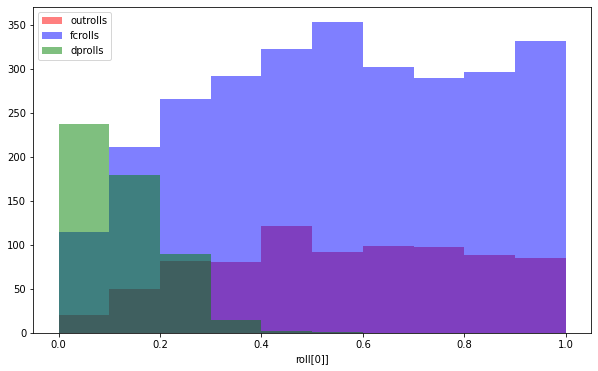

In [ ]:
# This shows the first roll is related to DP vs other
# The fc_dp notebook shows the second roll is related to FC vs Out
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     df[df['event_type'].isin(['FC','Out'])]['roll1'],
#     bins=10,
#     range=[0.,1.],
#     color="blue",
#     label="fcorout_rolls",
#     alpha = 0.5
# )
ax.hist(
    df[df['event_type']=='Out']['roll1'],
    bins=10,
    range=[0.,1.], 
    color="red",
    label="outrolls",
    alpha = 0.5
)
ax.hist(
    df[df['event_type']=='FC']['roll1'],
    bins=10,
    range=[0.,1.],
    color="blue",
    label="fcrolls",
    alpha = 0.5
)
ax.hist(
    df[df['event_type']=='DP']['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    label="dprolls",
    alpha = 0.5
)

ax.set_xlabel('bin counts')
ax.set_xlabel("roll[0]]")

ax.legend()

In [ ]:
X = dfc[
    [
        "roll1",
        "passed",
        # "batter_patheticism_with_vibe",
        # "batter_tragicness_with_vibe",
        "batter_inv_tragicness",
        "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        'ballpark_elongation',
        # 'runner_on_first_tragicness_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        # 'runner_on_first_indulgence_with_vibe',
        # 'ballpark_filthiness',
    ]
]

# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

,roll1,batter_inv_tragicness,pitcher_shakespearianism_with_vibe,fielder_tenaciousness_with_vibe,ballpark_elongation
0,0.802614,0.800000,0.698095,1.732106,0.500000
2,0.751626,0.963127,1.015963,0.393935,0.500000
3,0.338247,0.990000,1.015963,0.752914,0.500000
5,0.557095,0.900000,0.606569,0.541009,0.500000
6,0.827987,0.700000,0.737312,0.080102,0.500000
...,...,...,...,...,...
4107,0.793550,0.907696,0.602220,1.205594,0.547866
4108,0.775135,0.914951,0.602220,0.753333,0.547866
4109,0.130536,0.700589,0.413349,0.853119,0.575745
4111,0.792933,0.999000,0.999530,0.449642,0.575745


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

#trainedsvm = svm.LinearSVC(intercept_scaling=1000, dual=False, max_iter=100000, C=1000, class_weight="balanced").fit(
trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000, class_weight="balanced").fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[2105    1]
 [   0  286]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2106
        True       1.00      1.00      1.00       286

    accuracy                           1.00      2392
   macro avg       1.00      1.00      1.00      2392
weighted avg       1.00      1.00      1.00      2392

0.9995819397993311


In [ ]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.03765961]


[(1.0, 'roll1'),
 (-0.40934103997464055, 'pitcher_shakespearianism_with_vibe'),
 (0.18232675465931325, 'batter_inv_tragicness'),
 (0.17913579303974636, 'ballpark_elongation'),
 (-0.09976065651936168, 'fielder_tenaciousness_with_vibe')]

[0.03765961]
(-0.18232675465931325, 'batter_inv_tragicness')
(0.40934103997464055, 'pitcher_shakespearianism_with_vibe')
(0.09976065651936168, 'fielder_tenaciousness_with_vibe')
(-0.17913579303974636, 'ballpark_elongation')


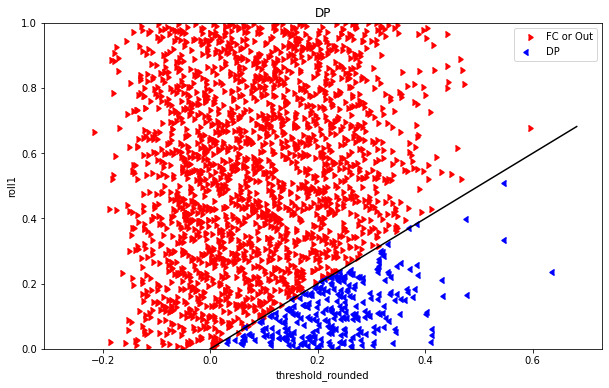

In [ ]:
# Manual threshold
dfc["threshold_rounded"] = -0.05 + 0.40 * dfc["pitcher_shakespearianism_with_vibe"] - 0.18 * dfc["batter_inv_tragicness"] + 0.10 * dfc['fielder_tenaciousness_with_vibe'] - 0.18 * (dfc["ballpark_elongation"] - 0.5)

# {
#     return "It's okay Joel"
# }

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="FC or Out",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    color="blue",
    label="DP",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("DP")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()
fig.savefig('/mnt/d/Pictures/dp.png')

0


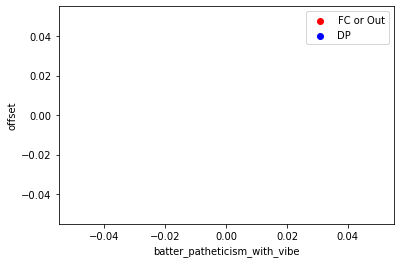

In [ ]:
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(len(outliers))

fig, ax = plt.subplots(1, facecolor='white')
x_val = "batter_patheticism_with_vibe"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="FC or Out",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="DP",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [ ]:
table = outliers
print(len(table))
#table = table[table['event_type'] == 'Out']
table[
    [
        "season",
        "day",
        "offset",
        "roll",
        "threshold_rounded",
        "event_type",
        #"baserunner_count",
        #"top_of_inning",
        # "inning",
        # "home_score",
        # "away_score",
        #"event_type",
        #"ballpark_filthiness",
        "pitcher_name",
        "fielder_name",
        "batter_name",
        "runner_on_first_name",
        "weather",
        "batter_mods",
        "pitcher_mods",
        "fielder_mods",
        "runner_on_first_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "game_id",
        "play_count",
    ]
].sort_values("threshold_rounded", ascending=True)
# len(table)

0


,season,day,offset,roll,threshold_rounded,event_type,pitcher_name,fielder_name,batter_name,runner_on_first_name,weather,batter_mods,pitcher_mods,fielder_mods,runner_on_first_mods,batting_team_mods,pitching_team_mods,game_id,play_count


In [ ]:
list(df.columns)

['event_type',
 'roll',
 'passed',
 'batter_buoyancy',
 'batter_divinity',
 'batter_martyrdom',
 'batter_moxie',
 'batter_musclitude',
 'batter_patheticism',
 'batter_thwackability',
 'batter_tragicness',
 'batter_coldness',
 'batter_overpowerment',
 'batter_ruthlessness',
 'batter_shakespearianism',
 'batter_suppression',
 'batter_unthwackability',
 'batter_base_thirst',
 'batter_continuation',
 'batter_ground_friction',
 'batter_indulgence',
 'batter_laserlikeness',
 'batter_anticapitalism',
 'batter_chasiness',
 'batter_omniscience',
 'batter_tenaciousness',
 'batter_watchfulness',
 'batter_pressurization',
 'batter_cinnamon',
 'batter_multiplier',
 'runner_on_first_buoyancy',
 'runner_on_first_divinity',
 'runner_on_first_martyrdom',
 'runner_on_first_moxie',
 'runner_on_first_musclitude',
 'runner_on_first_patheticism',
 'runner_on_first_thwackability',
 'runner_on_first_tragicness',
 'runner_on_first_coldness',
 'runner_on_first_overpowerment',
 'runner_on_first_ruthlessness',
 '